In [1]:
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tesserocr import PyTessBaseAPI, RIL, iterate_level, PT, OEM
%matplotlib inline

In [2]:
pytestapi_path = "C:\\Tesseract\\Tesseract-OCR-v5\\tessdata"

## File Path

In [4]:
IMAGE_PATH = "../datafiles/Page_2.jpg"
imageMAT = Image.open(IMAGE_PATH)

## Get Noise

In [41]:
def get_noise_val_Image(imagePIL, NoiseThreshold_ppage): # NoiseThreshold_ppage is b/w 0 and 1
    '''
    Params:
        imagePIL - PIL image object
        NoiseThreshold_ppage - %age noise threshold for an image range [0, 1]
        
    Returns:
        ratio of dark pixels and total pixels
        boolean page acceptance result based on noise ratio
        binary image with 0 representing noise pixels    
    '''
    
    BinaryThreshold = 195          #will come from config file
    
    grayPIL = imagePIL.convert('L')
    imageNUMPY = np.array(grayPIL, dtype='uint8')
    
    with PyTessBaseAPI(path = "C:\\Tesseract\\Tesseract-OCR-v5\\tessdata") as api:
        api.SetImage(imagePIL)
        api.Recognize()
        ri = api.GetIterator()
        level = RIL.SYMBOL
        
        for r in iterate_level(ri, level):
            x1, y1, x2, y2 = r.BoundingBox(level)
            imageNUMPY[y1:y2, x1:x2] = 255
    
    bin_ = np.zeros(imageNUMPY.shape)
    bin_ = np.where(imageNUMPY > BinaryThreshold, 1, 0)
    
    ratio = (bin_.size - bin_.sum())/bin_.size
    
    return ratio, ratio > NoiseThreshold_ppage, bin_ #returns the ratio, rejection result, binary_Image

In [42]:
def get_noise_params_PDF(PDFImages, NoiseThreshold_ppage  = 0.50):
    ''' IN-PROGRESS
    PDFImages: r x c x ch x num where num is number of images/pages
    '''
    PAGESCOUNT = len(PDFImages)
    pageNoiseFlag = [0]*PAGESCOUNT   #should be a class prop

    FORstart = time.time()
    
    for i in range(0, len(PDFImages)):
        #ITstart = time.time()
        if(get_noise_val_Image(PDFImages[i], NoiseThreshold_ppage)[1]): #rejection means: page is noisy
            pageNoiseFlag[i] = 1
        #print("Iteration-Time taken", time.time() - ITstart)
    
    print("FOR EndTime taken", time.time() - FORstart)
    
    return   sum(pageNoiseFlag)/PAGESCOUNT, pageNoiseFlag #returns the %age of pages that are noisy [0, 1]

### Using the functions

In [43]:
R, r, I = get_noise_val_Image(imageMAT, 0.50)

0.010638265002970885 False


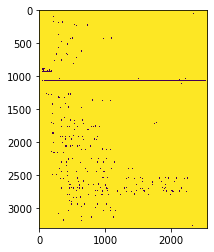

In [44]:
print(R, r)

plt.imshow(I)
plt.show()